# Share of ETH transfers over gas used

#### Maria Silva, October 2025

## 1. Imports and settings

Let's start by importing the necessary libraries and setting up some directories and files.


In [1]:
import os
import sys
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

In [2]:
# plotting theme
sns.set_theme(
    style="whitegrid", palette="Set2", rc={"figure.dpi": 500, "axes.titlesize": 15}
)

In [3]:
# Main directories and files
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
src_dir = os.path.join(repo_dir, "src")
data_dir = os.path.join(repo_dir, "data")
op_files_dir = os.path.join(data_dir, "aggregated_opcodes_sample", "*", "file.parquet")

## 2. Load data

Now, let's load the gas used per transaction.

In [4]:
# Load parquet file
tx_gas_info_df = pd.read_parquet(
    os.path.join(data_dir, "tx_gas_usage_sample.parquet")
)
# Print info
tx_gas_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994992 entries, 0 to 994991
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   block_height            994992 non-null  int64 
 1   tx_hash                 994992 non-null  object
 2   tx_gas_cost             994992 non-null  int64 
 3   tx_gas_limit            994992 non-null  int64 
 4   tx_input_zero_bytes     994992 non-null  int64 
 5   tx_input_nonzero_bytes  994992 non-null  int64 
 6   tx_input_data_cost      994992 non-null  int64 
 7   is_contract_creation    994992 non-null  bool  
 8   is_success              994992 non-null  bool  
dtypes: bool(2), int64(6), object(1)
memory usage: 55.0+ MB


Now, we can aggregate the gas used, depending on whether it was a ETH transfer or not:

In [5]:
agg_df = tx_gas_info_df.copy()
agg_df["is_eth_transfer"] = agg_df["tx_gas_cost"] == 21000
agg_df = (
    agg_df.groupby(["block_height", "is_eth_transfer"])["tx_gas_cost"]
    .sum()
    .reset_index()
    .pivot(columns="is_eth_transfer", index="block_height", values="tx_gas_cost")
)
agg_df.columns = ["others", "eth_transfers"]
agg_df["total"] = agg_df["others"] + agg_df["eth_transfers"]
agg_df[["others", "eth_transfers"]] = agg_df[["others", "eth_transfers"]].div(
    agg_df["others"] + agg_df["eth_transfers"], axis=0
)
agg_df

,others,eth_transfers,total
block_height,,,
22000017,0.992713,0.007287,17290285.0
22000092,0.953073,0.046927,17005037.0
22000130,0.963834,0.036166,27871409.0
22000174,0.966517,0.033483,21324439.0
22000227,0.943412,0.056588,21524131.0
...,...,...,...
22299725,0.886745,0.113255,6860595.0
22299836,0.976665,0.023335,35997715.0
22299872,0.961441,0.038559,31587926.0


In [6]:
count_df = tx_gas_info_df.copy()
count_df["is_eth_transfer"] = count_df["tx_gas_cost"] == 21000
count_df = (
    count_df.groupby(["block_height", "is_eth_transfer"])["tx_gas_cost"]
    .count()
    .reset_index()
    .pivot(columns="is_eth_transfer", index="block_height", values="tx_gas_cost")
)
count_df.columns = ["others", "eth_transfers"]
count_df["total"] = count_df["others"] + count_df["eth_transfers"]
count_df[["others", "eth_transfers"]] = count_df[["others", "eth_transfers"]].div(
    count_df["others"] + count_df["eth_transfers"], axis=0
)
count_df

,others,eth_transfers,total
block_height,,,
22000017,0.853659,0.146341,41.0
22000092,0.776471,0.223529,170.0
22000130,0.659574,0.340426,141.0
22000174,0.802326,0.197674,172.0
22000227,0.732719,0.267281,217.0
...,...,...,...
22299725,0.569767,0.430233,86.0
22299836,0.611650,0.388350,103.0
22299872,0.613333,0.386667,150.0


## Gas used EDA

In [7]:
agg_df["eth_transfers"].agg(["mean", "std", "median"])

mean      0.077402
std       0.048797
median    0.069194
Name: eth_transfers, dtype: float64

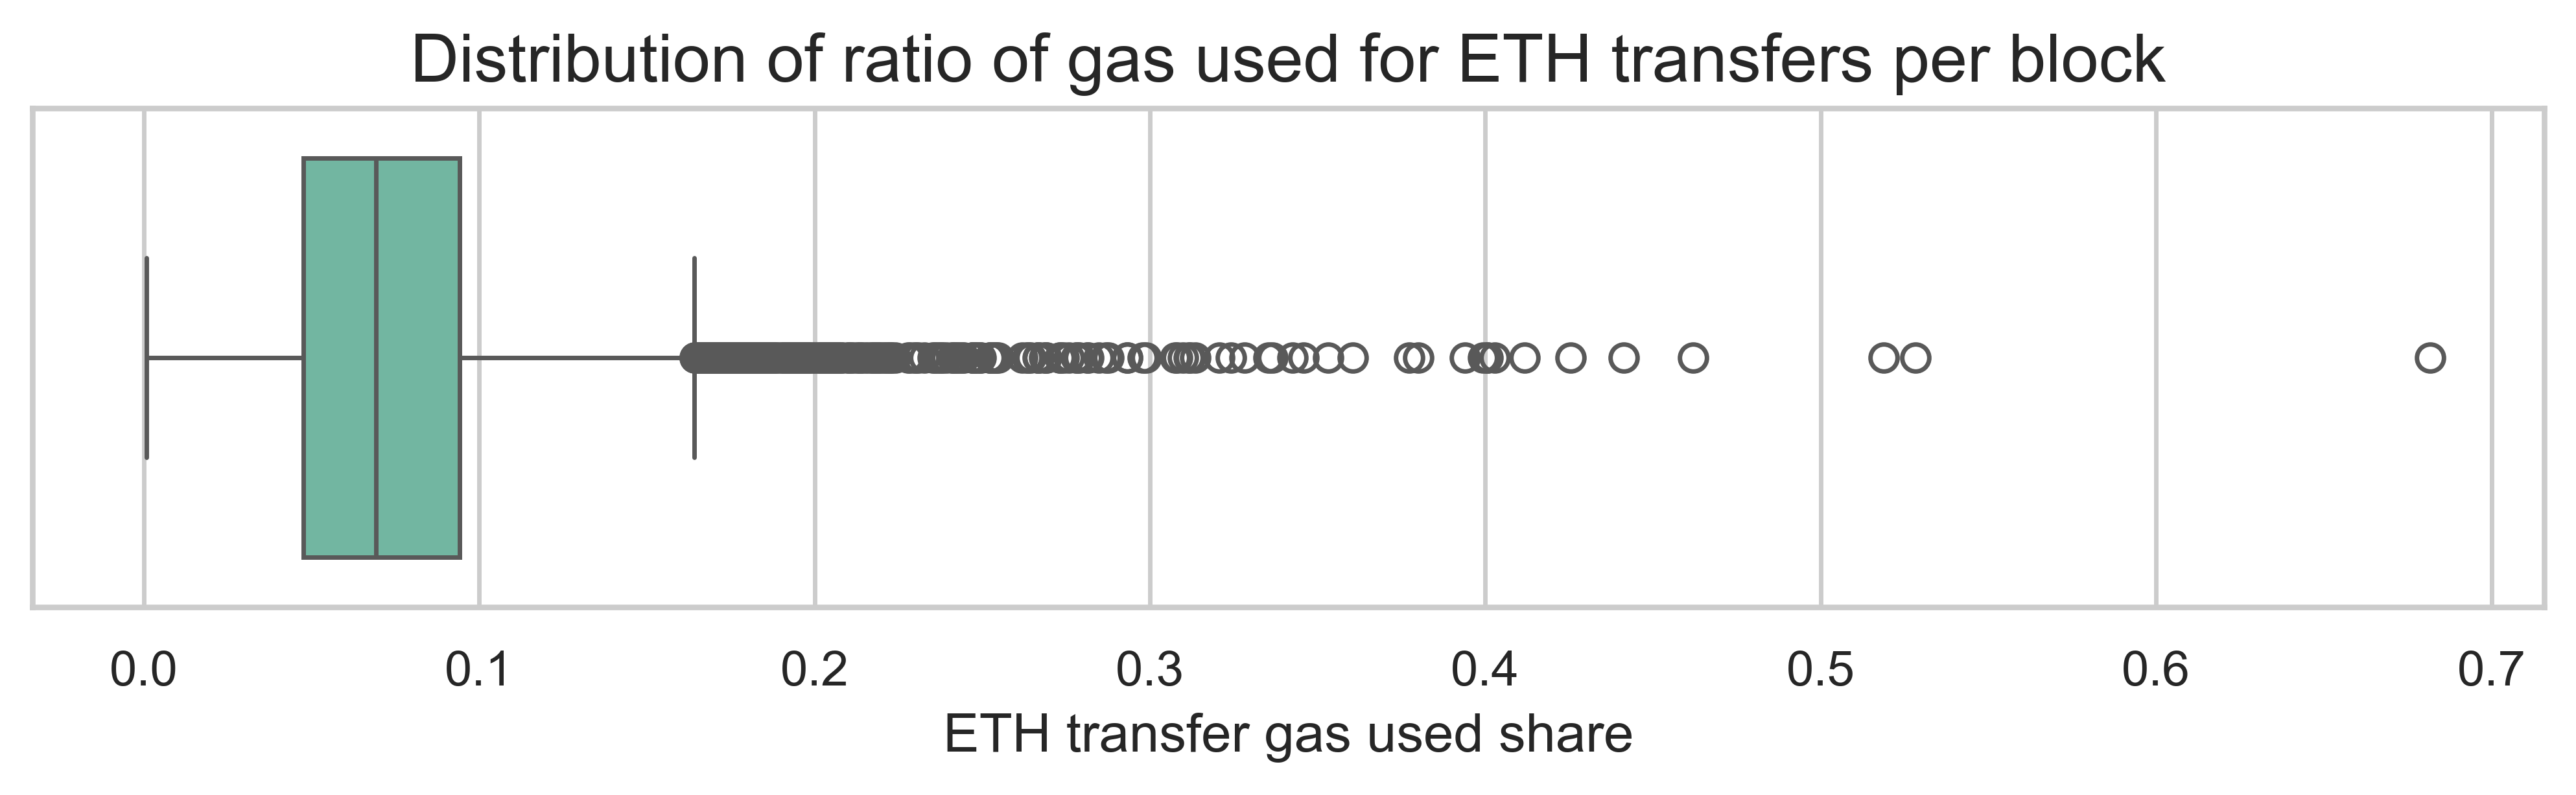

In [8]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=agg_df,
    x="eth_transfers"
)

plt.title("Distribution of ratio of gas used for ETH transfers per block")
plt.ylabel("")
plt.xlabel("ETH transfer gas used share")
plt.show()

## Tx count EDA

In [9]:
count_df["eth_transfers"].agg(["mean", "std", "median"])

mean      0.339339
std       0.099733
median    0.332042
Name: eth_transfers, dtype: float64

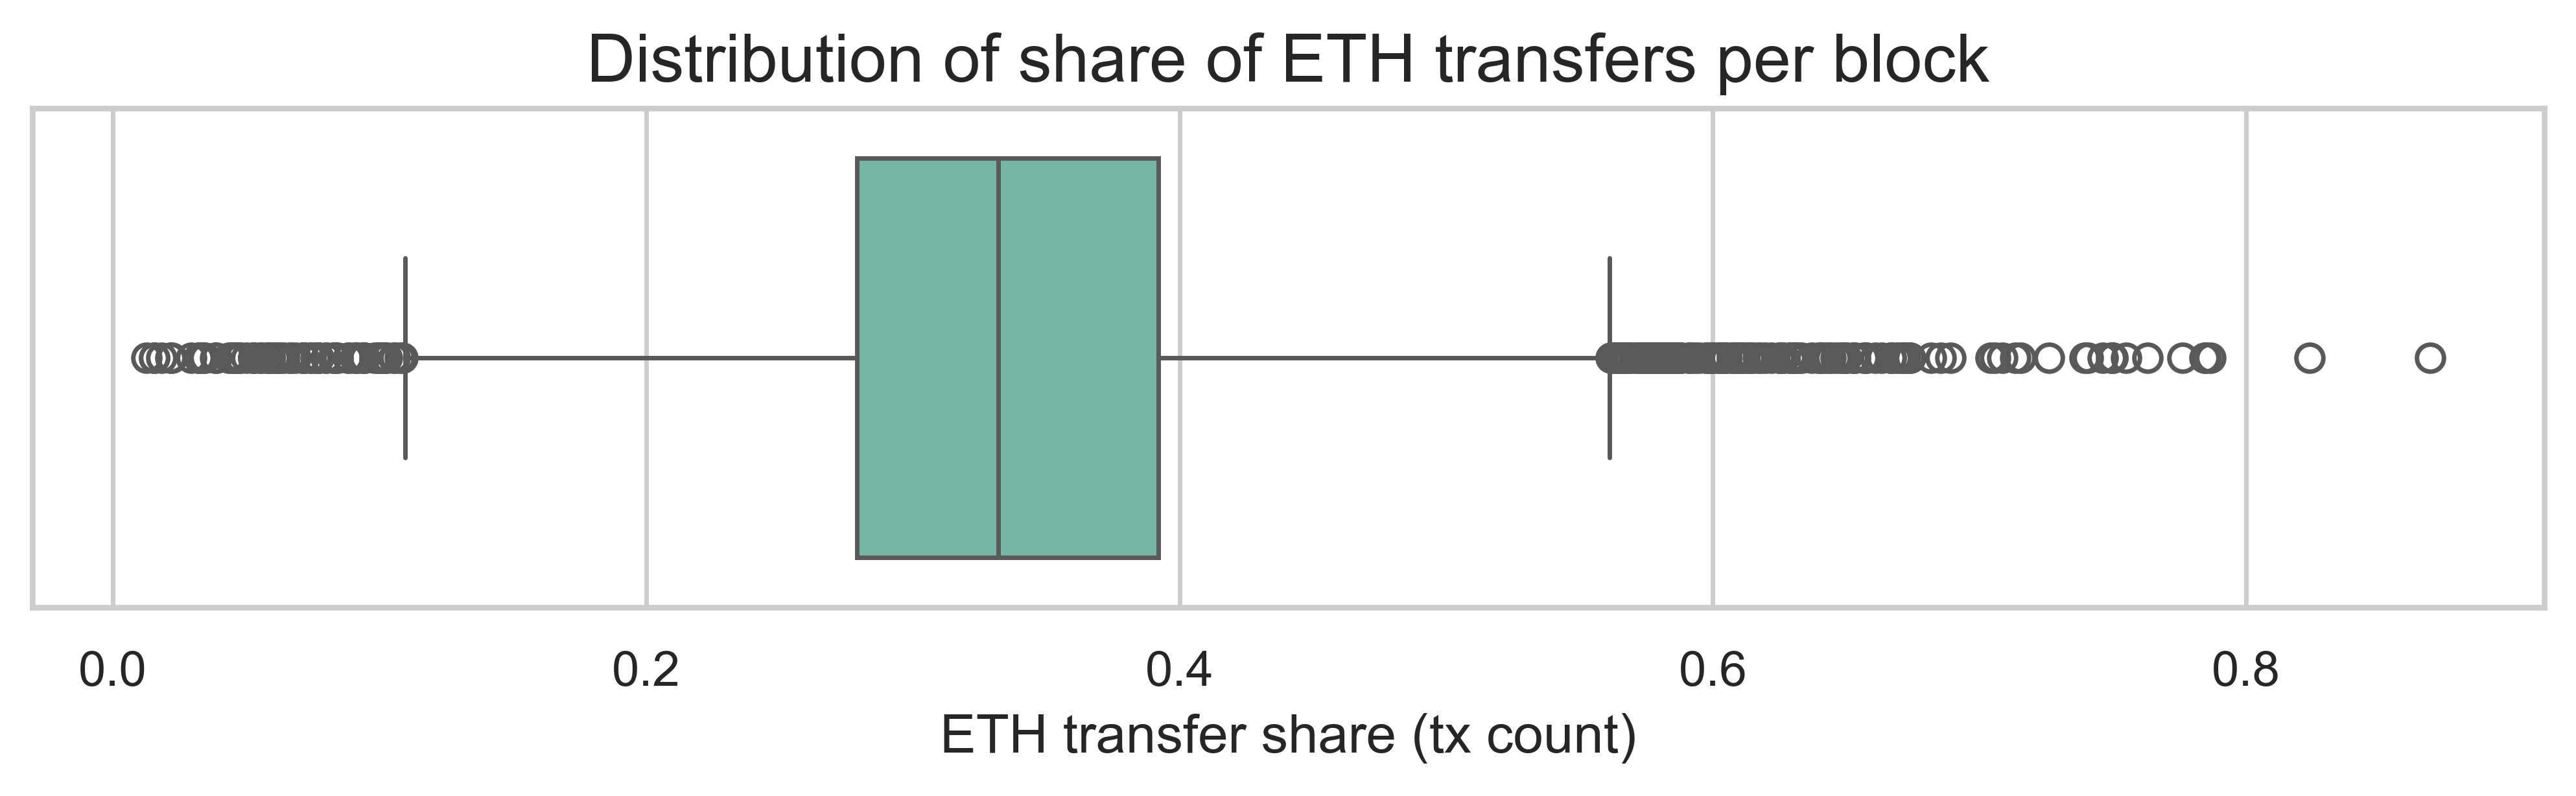

In [10]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=count_df,
    x="eth_transfers"
)

plt.title("Distribution of share of ETH transfers per block")
plt.ylabel("")
plt.xlabel("ETH transfer share (tx count)")
plt.show()